In [1]:
import os
import torch
import random
import numpy as np
from transformers import BertTokenizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device
from EDA import *

device(type='cuda')

In [2]:
# import data
def read_imdb(data_dir, is_train):
    data, labels = [], []
    pos_folder_name = os.path.join(data_dir, 'train' if is_train else 'test', 'pos')
    neg_folder_name = os.path.join(data_dir, 'train' if is_train else 'test', 'neg')

    for file in os.listdir(pos_folder_name):
        with open(os.path.join(pos_folder_name, file), 'rb') as f:
            if len(data)<10000:
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(1)
    for file in os.listdir(neg_folder_name):
        with open(os.path.join(neg_folder_name, file), 'rb') as f:
            if len(data)<20000:
                review = f.read().decode('utf-8').replace('\n', '')
                data.append(review)
                labels.append(0)
    return data, labels

In [3]:
data_dir = './aclImdb'
train_data = read_imdb(data_dir, is_train=True)
test_data = read_imdb(data_dir, is_train=False)

print('trainings:', len(train_data[0]))
print('tests:', len(test_data[0]))

for x, y in zip(train_data[0][:1], train_data[1][:1]):
    print('\nlabel:', y)
    print('review:', x)

trainings: 20000
tests: 20000

label: 1
review: Zentropa has much in common with The Third Man, another noir-like film set among the rubble of postwar Europe. Like TTM, there is much inventive camera work. There is an innocent American who gets emotionally involved with a woman he doesn't really understand, and whose naivety is all the more striking in contrast with the natives.<br /><br />But I'd have to say that The Third Man has a more well-crafted storyline. Zentropa is a bit disjointed in this respect. Perhaps this is intentional: it is presented as a dream/nightmare, and making it too coherent would spoil the effect. <br /><br />This movie is unrelentingly grim--"noir" in more than one sense; one never sees the sun shine. Grim, but intriguing, and frightening.


In [4]:
for i in test_data[0][5000:15000]:
    train_data[0].append(i)
for i in test_data[1][5000:15000]:
    train_data[1].append(i)
del test_data[0][5000:15000]
del test_data[1][5000:15000]

In [5]:
print('train length: ',len(train_data[1]))
print('test length: ',len(test_data[1]))

train length:  30000
test length:  10000


In [6]:
# shuffle
state = np.random.get_state()
np.random.shuffle(train_data[0])
np.random.set_state(state)
np.random.shuffle(train_data[1])


state1 = np.random.get_state()
np.random.shuffle(test_data[0])
np.random.set_state(state1)
np.random.shuffle(test_data[1])

In [7]:
# tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# print(len(tokenizer.vocab))

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [8]:

train_input_ids = []
train_attention_masks = []

n=30000

for sentence in train_data[0][:n]:
    encoded = tokenizer.encode_plus(
        text=sentence,  # the sentence to be encoded
        add_special_tokens=True,  # Add [CLS] and [SEP]
        max_length = 128,  # maximum length of a sentence
        pad_to_max_length = True,
#         padding='max_length',  # Add [PAD]s
        return_attention_mask = True,  # Generate the attention mask
        return_tensors = 'pt',  # ask the function to return PyTorch tensors
    )

    train_input_ids.append(encoded['input_ids'])
#     print(encoded['input_ids'])
    

    train_attention_masks.append(encoded['attention_mask'])

train_input_ids = torch.cat(train_input_ids)
train_attention_masks = torch.cat(train_attention_masks)
train_labels = torch.tensor(train_data[1][:n])
    

# # Get the input IDs and attention mask in tensor format
# input_ids = encoded['input_ids']
# attn_mask = encoded['attention_mask']


print('Original: ', train_data[0][0])
print('Token IDs:', train_input_ids[0])
print(train_labels[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/root/miniconda3/envs/myconda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2073: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  ***SPOILERS*** All too, in real life as well as in the movies, familiar story that happens to many young men who are put in a war zone with a gun, or rifle, in their hands. The case of young and innocent, in never handling or firing a gun, Jimmy Davis, Franchot Tone, has been repeated thousands of times over the centuries when men, like Jimmy Davis, are forced to take up arms for their country.<br /><br />Jimmy who at first wanted to be kicked out of the US Army but was encouraged to stay, by being belted in the mouth, by his good friend Fred P. Willis, Spencer Tracy, ended up on the front lines in France. With Jimmy's unit pinned down by a German machine gun nest he single handedly put it out of commission picking off some half dozen German soldiers from the safety of a nearby church steeple. It was when Jimmy gunned down the last surviving German, who raised his arms in surrender, that an artillery shell hit the steeple seriously wounding him.<br /><br />Recovering from hi

In [9]:
from torch.utils.data import TensorDataset, random_split


dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)


train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

27,000 training samples
3,000 validation samples


In [10]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler



batch_size = 32

train_dataloader = DataLoader(
            train_dataset,  
            sampler = RandomSampler(train_dataset), 
            batch_size = batch_size 
        )


validation_dataloader = DataLoader(
            val_dataset, 
            sampler = SequentialSampler(val_dataset), 
            batch_size = batch_size 
        )

In [11]:
from transformers import BertForSequenceClassification, AdamW, BertConfig


model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", 
    num_labels = 2, 
                   
    output_attentions = False, 
    output_hidden_states = False, 
    return_dict=False
)


model.cuda()

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [12]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8
                )

from transformers import get_linear_schedule_with_warmup


epochs = 3


total_steps = len(train_dataloader) * epochs


scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, 
                                            num_training_steps = total_steps)

In [13]:
import numpy as np


def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    
    elapsed_rounded = int(round((elapsed)))
    
   
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [14]:
torch.cuda.empty_cache()

In [15]:
import random
import numpy as np


seed_val = 42
batch_size = 16
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)


training_stats = []


total_t0 = time.time()

for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

   
    t0 = time.time()

    total_train_loss = 0

   
    model.train()


    for step, batch in enumerate(train_dataloader):

        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

  
        model.zero_grad()        

      
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)

  
        total_train_loss += loss.item()

   
        loss.backward()

        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

     
        optimizer.step()

      
        scheduler.step()

   
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================


    print("")
    print("Running Validation...")

    t0 = time.time()


    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        

        with torch.no_grad():        
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        
        total_eval_loss += loss.item()

        
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()


        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    

    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))


    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    844.    Elapsed: 0:00:07.
  Batch    80  of    844.    Elapsed: 0:00:14.
  Batch   120  of    844.    Elapsed: 0:00:22.
  Batch   160  of    844.    Elapsed: 0:00:29.
  Batch   200  of    844.    Elapsed: 0:00:36.
  Batch   240  of    844.    Elapsed: 0:00:43.
  Batch   280  of    844.    Elapsed: 0:00:50.
  Batch   320  of    844.    Elapsed: 0:00:58.
  Batch   360  of    844.    Elapsed: 0:01:05.
  Batch   400  of    844.    Elapsed: 0:01:12.
  Batch   440  of    844.    Elapsed: 0:01:19.
  Batch   480  of    844.    Elapsed: 0:01:27.
  Batch   520  of    844.    Elapsed: 0:01:34.
  Batch   560  of    844.    Elapsed: 0:01:41.
  Batch   600  of    844.    Elapsed: 0:01:47.
  Batch   640  of    844.    Elapsed: 0:01:55.
  Batch   680  of    844.    Elapsed: 0:02:01.
  Batch   720  of    844.    Elapsed: 0:02:08.
  Batch   760  of    844.    Elapsed: 0:02:16.
  Batch   800  of    844.    Elapsed: 0:02:23.
  Batch   840  of

In [16]:
import pandas as pd


pd.set_option('precision', 2)


df_stats = pd.DataFrame(data=training_stats)

df_stats = df_stats.set_index('epoch')

df_stats



,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.33,0.28,0.89,0:02:30,0:00:04
2,0.19,0.31,0.89,0:02:31,0:00:04
3,0.11,0.38,0.89,0:02:30,0:00:04


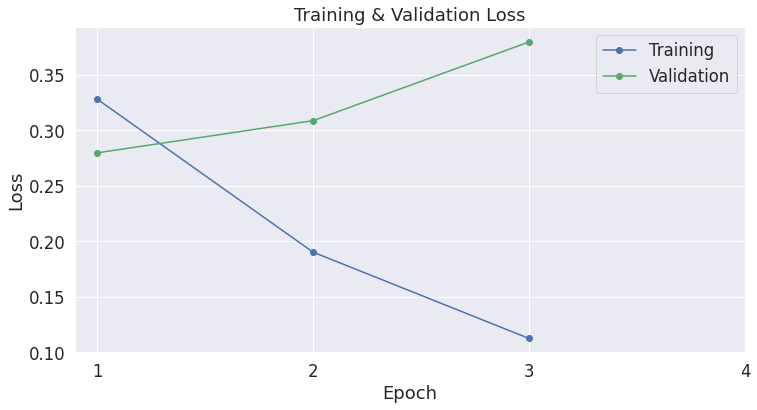

In [17]:
import matplotlib.pyplot as plt
#% matplotlib inline

import seaborn as sns

sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)


plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()


In [18]:

test_input_ids = []
test_attention_masks = []

n = 10000
for sentence in test_data[0][:n]:
    encoded = tokenizer.encode_plus(
        text=sentence,  # the sentence to be encoded
        add_special_tokens=True,  # Add [CLS] and [SEP]
        max_length = 128,  # maximum length of a sentence
        pad_to_max_length = True,
#         padding='max_length',  # Add [PAD]s
        return_attention_mask = True,  # Generate the attention mask
        return_tensors = 'pt',  # ask the function to return PyTorch tensors
    )
  
   
    test_input_ids.append(encoded['input_ids'])
#     print(encoded['input_ids'])
  
   
    test_attention_masks.append(encoded['attention_mask'])


test_input_ids = torch.cat(test_input_ids)
test_attention_masks = torch.cat(test_attention_masks)
test_labels = torch.tensor(test_data[1][:n])

batch_size = 32  


prediction_data = TensorDataset(test_input_ids, test_attention_masks, test_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

/root/miniconda3/envs/myconda/lib/python3.8/site-packages/transformers/tokenization_utils_base.py:2073: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [19]:

print('Predicting labels for {:,} test sentences...'.format(len(test_input_ids)))

model.eval()

# Tracking variables 
predictions , true_labels = [], []

for batch in prediction_dataloader:
  
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

   
    with torch.no_grad():
     
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

    logits = outputs[0]


    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    #total_eval_accuracy += flat_accuracy(logits, label_ids)


    predictions.append(logits)
    true_labels.append(label_ids)
#avg_val_accuracy = flat_accuracy(predictions, true_labels)    
#avg_val_accuracy = total_eval_accuracy / len(prediction_dataloader)
#print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
print('    DONE.')

Predicting labels for 10,000 test sentences...
    DONE.


In [20]:
print('Positive samples: %d of %d (%.2f%%)' % (sum(test_data[1]), len(test_data[1]), (sum(test_data[1]) / len(test_data[1]) * 100.0)))


Positive samples: 5000 of 10000 (50.00%)


In [22]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

pred_labels_i = []
# For each input batch...
for i in range(len(true_labels)):
    pred_labels_i += list(np.argmax(predictions[i], axis=1).flatten())

    
true_labels_list = []
for i in test_labels:
    true_labels_list.append(i.item())

accuracy_score(pred_labels_i, true_labels_list)

0.8901

Classification Report:
              precision    recall  f1-score   support

           1     0.8852    0.8964    0.8908      5000
           0     0.8951    0.8838    0.8894      5000

    accuracy                         0.8901     10000
   macro avg     0.8902    0.8901    0.8901     10000
weighted avg     0.8902    0.8901    0.8901     10000



[Text(0, 0.5, 'POS'), Text(0, 1.5, 'NEG')]

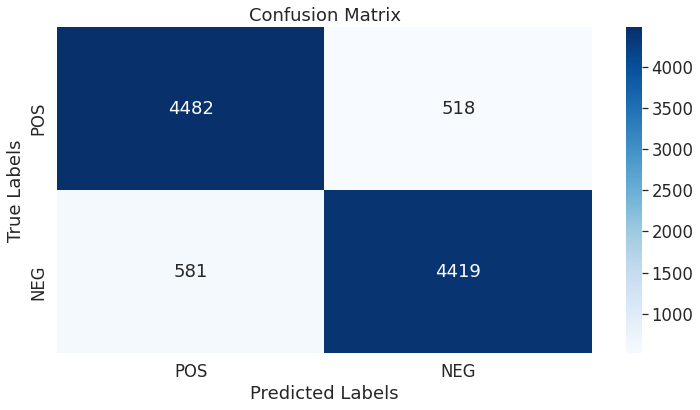

In [23]:
print('Classification Report:') 
print(classification_report(true_labels_list, pred_labels_i, labels=[1,0], digits=4)) 

cm = confusion_matrix(true_labels_list, pred_labels_i, labels=[1,0]) 
ax= plt.subplot() 
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d") 
ax.set_title('Confusion Matrix') 
ax.set_xlabel('Predicted Labels') 
ax.set_ylabel('True Labels') 
ax.xaxis.set_ticklabels(['POS', 'NEG']) 
ax.yaxis.set_ticklabels(['POS', 'NEG']) 